## Project 5: Interpretability
* **Background**: Interpretable ML refers to methods and models that make the behavior and predictions of ML systems understandable to humans. The higher the interpretability, the easier it is for someone to understand why certain decisions or predictions were made by our model. In some cases, knowing why your model predicted the way it did can help you learn more about the problem, the data and in which scenarios your model may fail.
* **Problem statement**: The focus of this project is to design, implement, test, compare, and document a selection of model interpretability methods in order to reason about why our models make the decisions they do with applications to, e.g. regression or classification problems. The algorithms must be optimized with regard to applicable properties of explanation methods (see IML Sec. 2.5), i.e. results must be shown such that end-users readily can see an explanation for a prediction. To quantify the quality of the methods, comparative evaluations should be carried out via objective metrics and the algorithms should be assessed against state of the art.
* **Technologies (inspiration)**:
    * scikit-learn, Machine Learning in Python. [Link](https://scikit-learn.org/stable/)
    * C. Davidson-Pilon, "lifelines: survival analysis in Python", Journal of Open Source Software, Vol. 4, No. 40, 2019. [Link](https://doi.org/10.21105/joss.01317)
    * S. Pölsterl, "scikit-survival: A Library for Time-to-Event Analysis Built on Top of scikit-learn," Journal of Machine Learning Research, vol. 21, no. 212, 2020. [Link](https://www.jmlr.org/papers/volume21/20-729/20-729.pdf)
    * M. Abadi et al., "Tensorflow: A system for large-scale machine learning", 12th USENIX Symposium on Operating Systems Design and Implementation (OSDI 16), pp. 265–283, 2016. [Link](https://www.tensorflow.org/)
* **Data-sets (inspiration)**:
    * P. Perera, "The Boston Housing Dataset", regression, 2018. [Link](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset)
    * P. Campanelli, "League of Legends Ranked Matches", classification, 2017. [Link](https://www.kaggle.com/datasets/paololol/league-of-legends-ranked-matches)
    * C. Lillelund, "CS:GO Round Winner Classification", classification, 2020. [Link](https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification)
    * S. Lundberg, "ImageNet50", classification, 2018. [Link](https://shap.readthedocs.io/en/latest/generated/shap.datasets.imagenet50.html)
    * S. Lundberg, "NHANES", survival analysis, 2018. [Link](https://shap.readthedocs.io/en/latest/generated/shap.datasets.nhanesi.html)
* **References (inspiration)**:
    * S. Lundberg and S. Lee, "A Unified Approach to Interpreting Model Predictions", Conf. on Neural Information Processing Systems, 2017. [Link](https://shap.readthedocs.io/en/latest/)
    * M. Ribeiro, S. Singh and C. Guestrin. "Why should I trust you?: Explaining the predictions of any classifier", Conf. on Knowledge Discovery and Data Mining, 2016. [Link](https://arxiv.org/abs/1602.04938)

Inspiration: https://www.kaggle.com/code/cheedcheed/what-features-predict-the-winner-lightgbm-shap


In [63]:
import numpy as np
import shap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import lightgbm as lgb


plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline

In [64]:
""" Create the dataset """
df = pd.read_csv('csgo_round_snapshots.csv')
display(df.head())
display(df.describe())

print(f"Number of samples: {df.shape[0]}")

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


Number of samples: 122410


In [65]:
# Split the data into target and features
y = df['round_winner'] # categorical target
X = df.drop(['round_winner'], axis=1)

In [66]:
# print the shape of the DataFrame
print('DataFrame shape:', X.shape)
# print the column names of the DataFrame
print('Column names:', X.columns)

DataFrame shape: (122410, 96)
Column names: Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',

In [67]:
""" Encoding the features """
objects = ['map', 'bomb_planted']

# Using OneHotEncoder to encode the categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# WARNING: 
# Depending on sklearn version the last argument 
# for 'OneHotEncoder' should either be "sparse=" or "sparse_output="

X_encoded = pd.DataFrame(ohe.fit_transform(X[['map', 'bomb_planted']]))
X_encoded.columns = ohe.get_feature_names_out(['map', 'bomb_planted'])
X_encoded.index = X.index

# Concatenate the encoded variables with the original dataset
numerical_X = X.drop(['map', 'bomb_planted'], axis=1)
X = pd.concat([numerical_X, X_encoded], axis=1)

""" Encoding the target """
# Using LabelEncoder to encode the categorical variables
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)



In [69]:
# Splitting the data into train and test sets (80% - 20% respectively)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

In [79]:
params = {
    "learning_rate": 0.05,      # Controls the step size of the optimization algorithm
    "boosting_type": "gbdt",    # GBDT is good for binary classification tasks with nonlinear relations
    "objective": "binary",      # Type of objective
    "metric": "binary_logloss", # "binary_logloss" is typically used for binary classification
    "num_leaves": 16,           # Maximum tree leaves for base learners
    "min_data": 128,            # Minimum number of data points needed to form a new tree leaf
    "boost_from_average": True  # Use the average prediction as the initial prediction
}

model = lgb.train(params, 
                  train_set=lgb_train, 
                  num_boost_round=25000, 
                  valid_sets=[lgb_test], 
                  early_stopping_rounds=50, 
                  verbose_eval=1000)



'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 49937, number of negative: 47991
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3783
[LightGBM] [Info] Number of data points in the train set: 97928, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509936 -> initscore=0.039749
[LightGBM] [Info] Start training from score 0.039749
Training until validation scores don't improve for 50 rounds
[1000]	valid_0's binary_logloss: 0.398649
[2000]	valid_0's binary_logloss: 0.37435
[3000]	valid_0's binary_logloss: 0.355828
[4000]	valid_0's binary_logloss: 0.340631
[5000]	valid_0's binary_logloss: 0.328612
[6000]	valid_0's binary_logloss: 0.318937
[7000]	valid_0's binary_logloss: 0.309575
[8000]	valid_0's binary_logloss: 0.303158
[9000]	valid_0's binary_logloss: 0.296481
[10

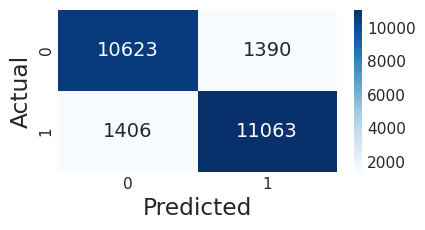

Accuracy: 0.8857936443101054
Recall: 0.887240356083086
Precision: 0.8883803099654701


In [80]:
# Create confusion matrix
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Create confusion matrix
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Calculate the precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

In [83]:

# Show prediction for index n of the test set
for n in range(0, 10):
    print(f"Prediction: {model.predict(X_test.iloc[n:n+1])} with label {y_test[n]}")

Prediction: [0.66541379] with label 1
Prediction: [0.99790021] with label 1
Prediction: [4.91276864e-05] with label 0
Prediction: [0.25210258] with label 0
Prediction: [0.95805715] with label 1
Prediction: [0.00034334] with label 0
Prediction: [0.01258495] with label 0
Prediction: [0.05123381] with label 0
Prediction: [0.94298035] with label 1
Prediction: [0.0181181] with label 0


# Explainability methods

In [84]:

# Initialize necessary JavaScript code to render SHAP plots in the notebook 
shap.initjs()

In [177]:
explainer = shap.TreeExplainer(model)

# Load shap_values from file if it exists
try:
    shap_values = np.load('shap_values.npy')
    print('Loaded shap_values from file')
except:
    # Create the explainer
    shap_values = explainer.shap_values(X)
    np.save('shap_values.npy', shap_values)
    print('Could not load shap_values from file')

Loaded shap_values from file


In [86]:
# Sampling 100 instances to reduce the computational cost
num_samples = 100
X100 = shap.utils.sample(X, num_samples) 

Index(['ct_armor', 't_armor', 'ct_money', 't_money', 't_helmets', 'time_left',
       'ct_score', 't_score', 't_health', 'ct_health', 'ct_defuse_kits',
       't_players_alive', 'ct_helmets', 'ct_weapon_usps', 'bomb_planted_False',
       't_weapon_glock', 'ct_weapon_m4a4', 't_weapon_ak47', 't_weapon_sg553',
       't_grenade_molotovgrenade'],
      dtype='object')


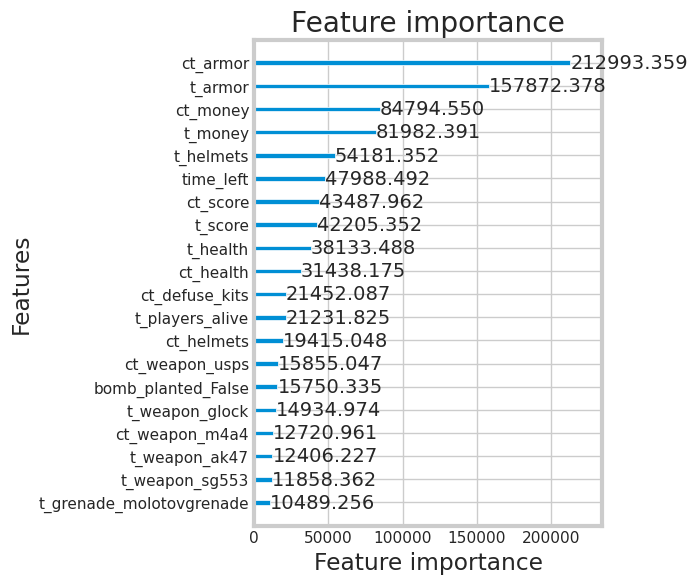

In [87]:
# Show the feature importance
lgb.plot_importance(model, figsize=(4, 6), importance_type='gain', max_num_features=20)

# Create a list of the top 20 features
top_features = X.columns[list(model.feature_importance(importance_type='gain').argsort()[-20:][::-1])]
print(top_features)

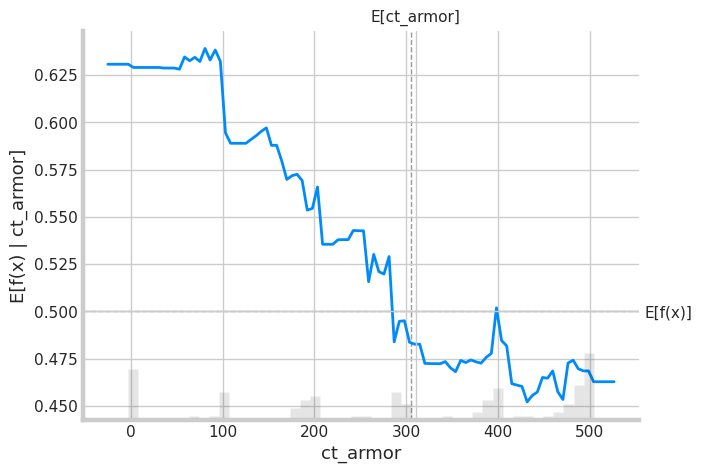

In [88]:
plot_num = 1 # Change this to plot more features

for f in top_features[:plot_num]:
    shap.partial_dependence_plot(
        f, model.predict, X100, ice=False,
        model_expected_value=True, feature_expected_value=True
    )


In [114]:
# compute the SHAP values for the linear model
explainer100 = shap.Explainer(model.predict, X100)
shap_values100 = explainer100(X100)

Permutation explainer: 101it [22:21, 13.55s/it]                         


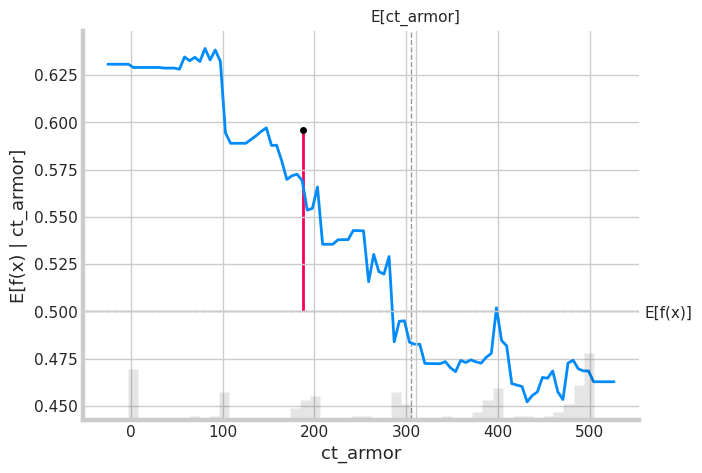

In [117]:
# make a standard partial dependence plot
sample_ind = 25
shap.partial_dependence_plot(
    "ct_armor", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values100[sample_ind:sample_ind+1,:]
)

In [118]:

display(X100.iloc[sample_ind:sample_ind+1,:])

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo,bomb_planted_False,bomb_planted_True
82457,34.95,2.0,0.0,112.0,176.0,187.0,190.0,4900.0,1250.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


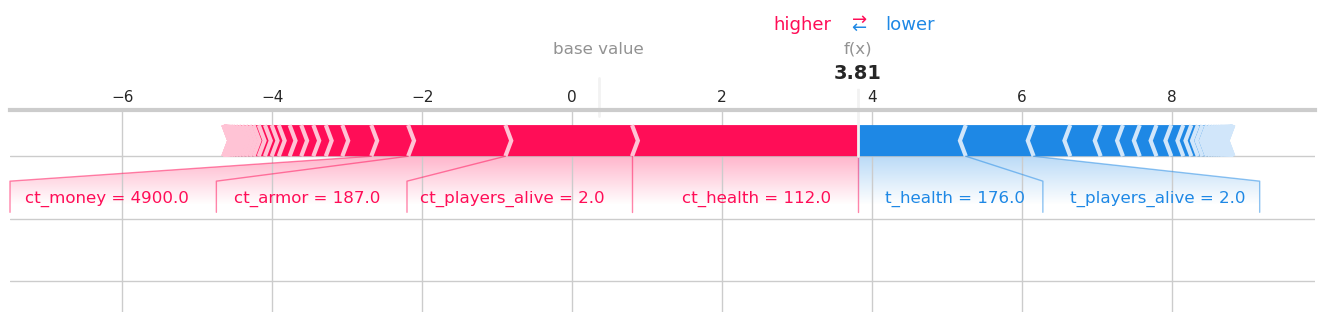

In [192]:
# Create a foceplot for sample_ind
shap.force_plot(explainer.expected_value[0], shap_values[1][sample_ind,:], X100.iloc[sample_ind,:], matplotlib=True,figsize=(15, 2.5))


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


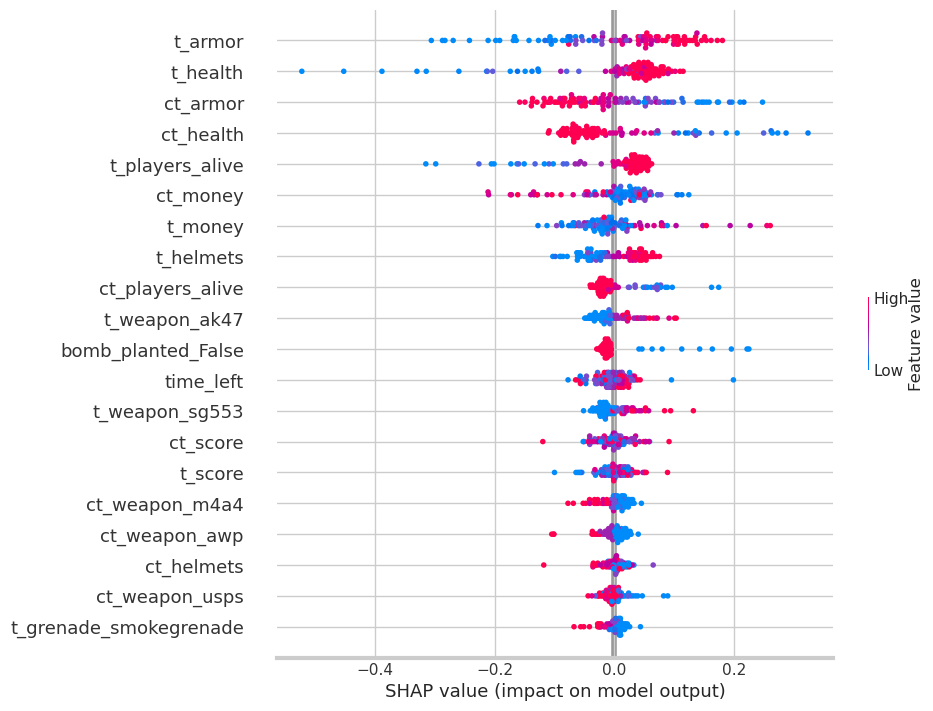

In [191]:
# summary plot
shap.summary_plot(shap_values100, X100, plot_size=(8, 8))


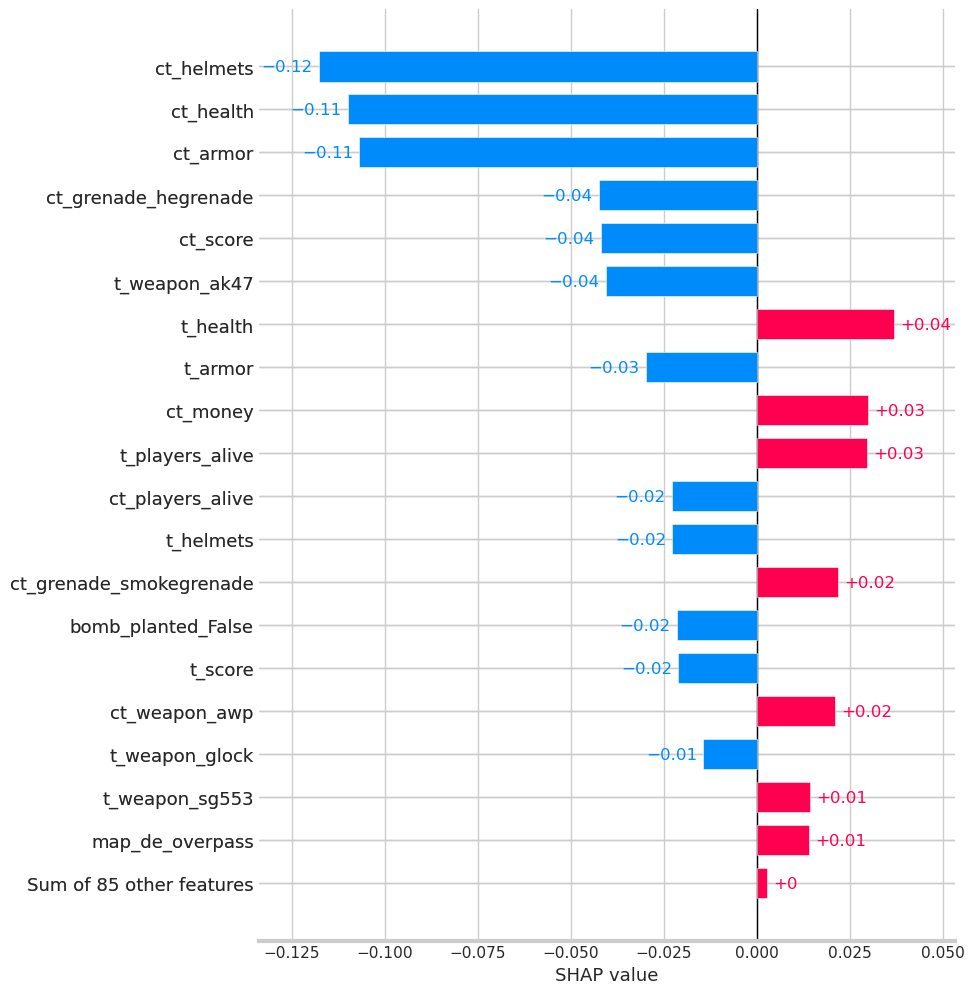

In [193]:

# explainer = shap.Explainer(model, X_train, feature_dependence="interventional")
shap.plots.bar(shap_values100[0], max_display=20)


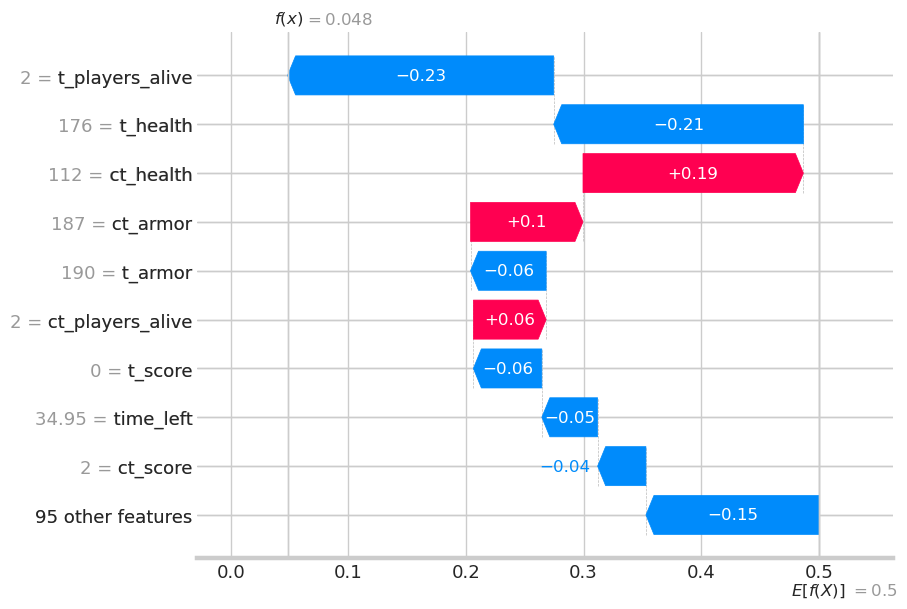

In [194]:
# Create waterfall plot
shap.plots.waterfall(shap_values100[sample_ind])


[Text(0.5, 0.03, 'ct_armor'),
 Text(1.5, 0.03, 't_armor'),
 Text(2.5, 0.03, 'ct_money'),
 Text(3.5, 0.03, 't_money'),
 Text(4.5, 0.03, 't_helmets'),
 Text(5.5, 0.03, 'time_left'),
 Text(6.5, 0.03, 't_score'),
 Text(7.5, 0.03, 'ct_score'),
 Text(8.5, 0.03, 't_health'),
 Text(9.5, 0.03, 'ct_health'),
 Text(10.5, 0.03, 'ct_defuse_kits'),
 Text(11.5, 0.03, 't_players_alive'),
 Text(12.5, 0.03, 'ct_helmets'),
 Text(13.5, 0.03, 'bomb_planted_False'),
 Text(14.5, 0.03, 'ct_weapon_usps'),
 Text(15.5, 0.03, 't_weapon_glock'),
 Text(16.5, 0.03, 'ct_weapon_m4a4'),
 Text(17.5, 0.03, 't_weapon_ak47'),
 Text(18.5, 0.03, 't_weapon_sg553'),
 Text(19.5, 0.03, 'ct_weapon_awp')]

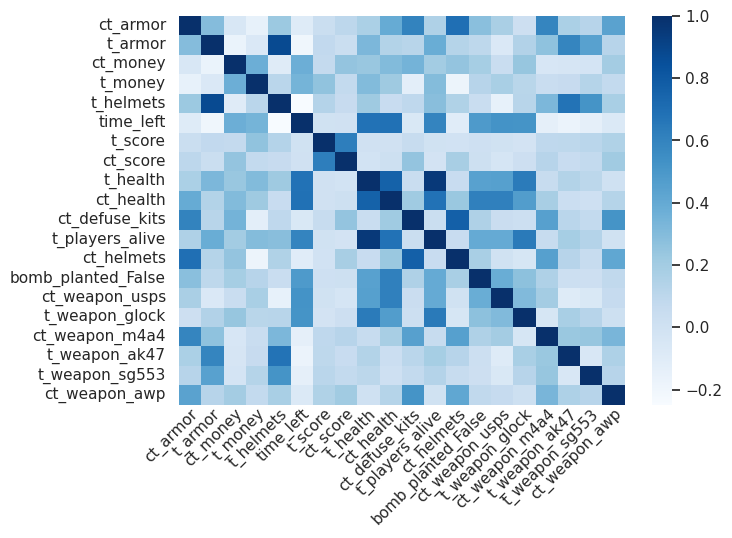

In [40]:
# Create a heatmap of corralation between the top 20 features with perason method
corr = X[top_features[:20]].corr(method='pearson')
# Plot the heatmap as a square
sns.set()
ax = sns.heatmap(corr, annot=False, fmt='.2f', cmap='Blues', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', rotation_mode='anchor', y=0.03)


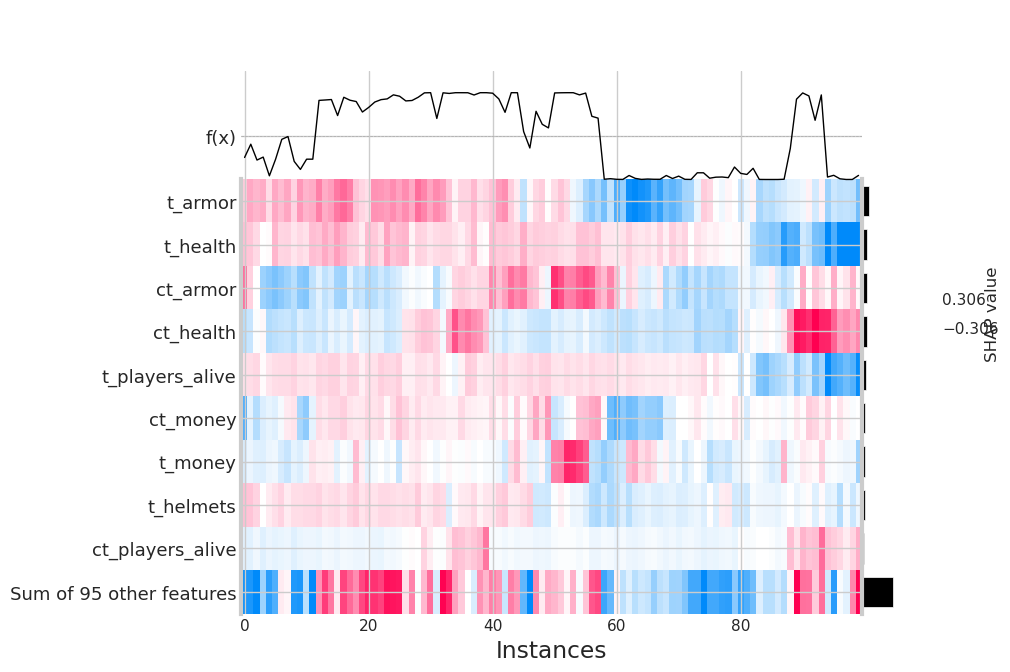

In [164]:
shap.plots.heatmap(shap_values100)

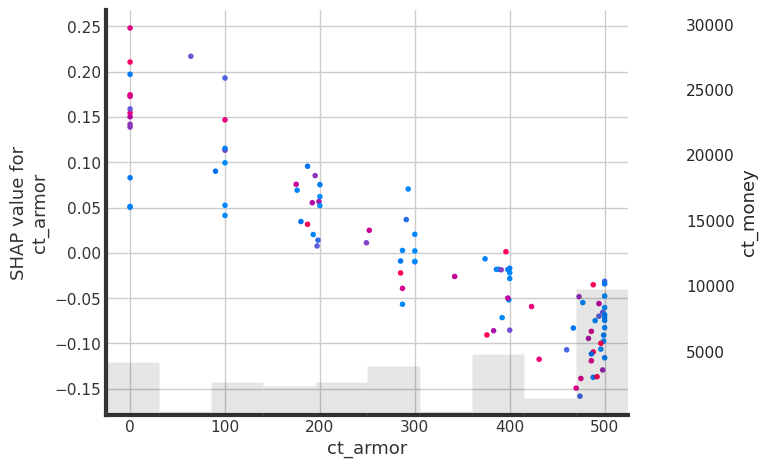

In [185]:
# Create a scatter plot of the top 20 features
shap.plots.scatter(shap_values100[:,"ct_armor"], color=shap_values100)

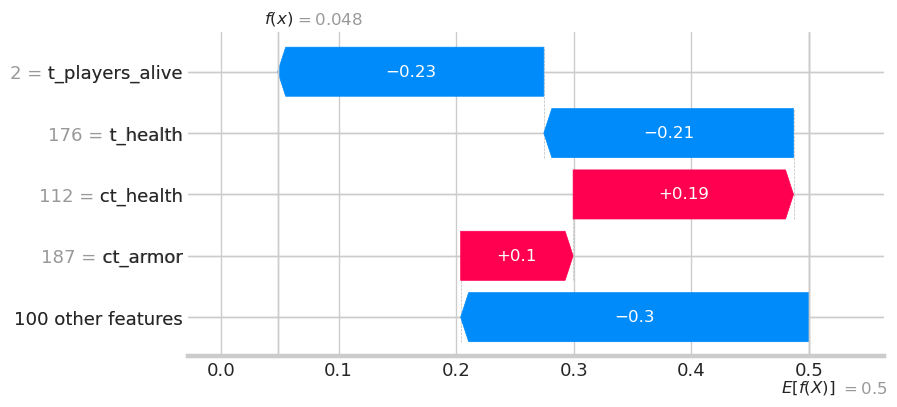

In [190]:
# Create a waterfall plot that is short in the x-axis
shap.plots.waterfall(shap_values100[sample_ind], max_display=5)
